# More SMILE!!!
## Computational Methods in Psychology and Neuroscience
### Psychology 4215/7215 --- Fall 2023
By: Per B. Sederberg, PhD



# Lesson Objectives

Upon completion of this lesson, students should have learned:

1. How to update SMILE to the latest version
2. How to present images
3. To visualize the DAG for an experiment
4. How to lay out visual states on the screen
5. To log information for easy analysis
6. How to write subroutines to organize your code
7. How to include mouse interaction


# Updating SMILE

- First, activate your smile virtual environment:

```bash
conda activate smile
```

- You can test whether there is a new version Kivy, which is the primary dependency of SMILE:

```bash
conda install -c conda-forge kivy
```

- Then you can update SMILE right from the GitHub repository (note the upgrade option at the end):

```bash
pip install --upgrade git+https://github.com/compmem/smile
```

# Understanding Flow

- By default, everything in SMILE proceeds sequentially (i.e., in *serial*) in the order the states are added.
  - The `Serial` parent state manages starting the next child state when the previous child finishes.
- The `Parallel` state allows for multiple states to run *at the same time*.
  - By default the `Parallel` state is done with all its child states are done.
  - The `blocking` attribute allows ending a `Parallel` state when all non-blocking states are done.
  - The `UntilDone` and `Meanwhile` parent states simply create Serial/Parallel states with specific blocking values.

## These are the same

In [ ]:
# load in smile states
from smile.common import *

# create an experiment instance
exp = Experiment(show_splash=False, resolution=(1024,768))

# METHOD 1
Label(text='Press Any Key')
with UntilDone():
    KeyPress()
Wait(.5)

# METHOD 2
with Parallel():
    Label(text='Press Any Key', blocking=False)
    KeyPress()
Wait(.5)

# METHOD 3
KeyPress()
with Meanwhile():
    Label(text='Press Any Key')

    
Wait(.5)

exp.run()


## Keeping track of variables

Any variable needed at *run-time* must be *attached* to the state machine. 

In [11]:
# load in smile states
from smile.common import *

# create an experiment instance
exp = Experiment(show_splash=False, resolution=(1024,768))

KeyPress()
with Meanwhile():
    # attach a variable reference
    exp.current_value = 0
    with Loop():
        exp.current_value = exp.current_value + 1
        Label(text=Ref(str, exp.current_value), duration=1.0, 
              font_size=50)
Wait(.5)

exp.run()

# Showing Images


In [12]:
# load in smile states
from smile.common import *

# create an experiment instance
exp = Experiment(show_splash=False, resolution=(1024,768))

# show an image until keypress
Image(source="../assignments/outdoor/out0099_new.jpg")
with UntilDone():
    KeyPress()

# show a larger image until keypress (note allow_stretch)
Image(source="../assignments/outdoor/out0099_new.jpg", 
      width=200, height=400, allow_stretch=True, keep_ratio=False)
with UntilDone():
    KeyPress()

# run the experiment
exp.run()

# Visualizing State Machines

- A SMILE experiment is a directed acyclic graph (DAG)
- It's possible to visualize the full hierarchy of states

- Note, this will require that you install pydot:

```bash
conda install pydot
```

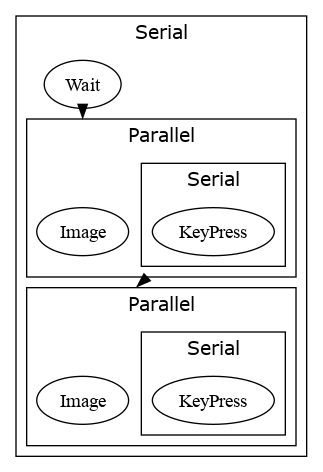

In [13]:
from smile.dag import DAG
d = DAG(exp)
d.view_png()

# Advanced Placement

- All visual states have a coordinate system based on the screen.
- You can place any visual state relative to either the screen or other visual states:

In [5]:
# load in smile states
from smile.common import *

# create an experiment instance
exp = Experiment(show_splash=False, resolution=(1024,768))

# show images and labels until keypress
with Parallel():
    # place images based on the screen coords
    out_im = Image(source="../assignments/outdoor/out0091_new.jpg",
                   left=exp.screen.center_x + 100)
    in_im = Image(source="../assignments/indoor/in0021.jpg",
                  right=exp.screen.center_x - 100)
    
    # place labels based on the images
    out_txt = Label(text='Outdoor', font_size=50, 
                    center_bottom=out_im.center_top)
    in_txt = Label(text='Indoor', font_size=50, 
                   center_bottom=in_im.center_top)
with UntilDone():
    KeyPress()

# run the experiment
exp.run()

## Conditional Execution

Your state machine can branch by making use of conditionals, i.e., `If`, `Else`, and `Elif`.

In [18]:
# load in smile states
from smile.common import *

# create an experiment instance
exp = Experiment(show_splash=False, resolution=(1024,768))

with Parallel():
    with Serial(blocking=False):
        exp.current_value = 0
        with Loop():
            # set the new value
            exp.current_value = exp.current_value + 1
            
            with If(exp.current_value % 2 == 0):
                # it's an even number, so move it left
                exp.offset = -100
            with Else():
                # it's odd, so move it right
                exp.offset = 100

            Label(text=Ref(str, exp.current_value), duration=1.0, 
                  font_size=50,
                  center_x = exp.screen.center_x + exp.offset)
    KeyPress()
Wait(.5)

exp.run()

# Mouse States

- The mouse is hidden by default
- You can add in a mouse cursor with the `MouseCursor` state
- It's possible to trigger events based on mouse location

In [2]:
from smile.common import *

# set up an experiment
exp = Experiment(show_splash=False, debug=True)

Wait(0.5)

KeyPress()
with Meanwhile():
    MouseCursor()
    
exp.run()

In [15]:
from smile.common import *

# set up an experiment
exp = Experiment(show_splash=False, debug=True)

Wait(0.5)

# display a rectangle and the mouse cursor
with Parallel():
    rect = Rectangle(center_bottom=exp.screen.center_bottom,
                     color='white')
    MouseCursor()
with UntilDone():
    Wait(until=MouseWithin(rect))

# put up two new rectangles
with Parallel():
    choice_A = Rectangle(left_top=(exp.screen.left + 100, exp.screen.top - 100))
    choice_B = Rectangle(right_top=(exp.screen.right - 100, exp.screen.top - 100))
    mrec = Record(mouse_pos=MousePos())
    MouseCursor()
with UntilDone():
    mwa = MouseWithin(choice_A)
    mwb = MouseWithin(choice_B)
    w = Wait(until= mwa | mwb)
    with If(mwa):
        Debug(choice='A',
              rt=w.event_time['time'] - choice_A.appear_time['time'])
    with Else():
        Debug(choice='B',
              rt=w.event_time['time'] - choice_B.appear_time['time'])

exp.run()

DEBUG (file: '/tmp/ipykernel_1078212/1408427399.py', line: 30) - lag=0.002346s
  choice: 'B'
  rt: 1.6295217480510473


# Animations

- It's possible to link the attributes of a visual state to a function.
- Here we move rectangles based on the mouse position:

In [8]:
from smile.common import *

# set up an experiment
exp = Experiment(show_splash=False, debug=True)

Wait(1.0)

with Parallel():
    rect = Rectangle(center_bottom=exp.screen.center_bottom,
                     color='white')
    r2 = Rectangle(bottom=rect.bottom, color='purple')
    r3 = Rectangle(center_top=exp.screen.center_top, color='green')
    MouseCursor()
with UntilDone():
    Wait(until=MouseWithin(rect))
    with Meanwhile():
        with Parallel():
            r2.animate(center_x=lambda t, initial: MousePos()[0])
            r3.animate(center_y=lambda t, initial: MousePos()[1])

exp.run()

# Sliding

- Visual States have a slide method to set new parameter values over a duration.

In [9]:
from smile.common import *

# set up the experiment
exp = Experiment(show_splash=False, debug=True, resolution=(1024, 768))

# initial wait
Wait(.25)

# Put up a circle
circ = Ellipse(color=(jitter(0, 1),
                      jitter(0, 1),
                      jitter(0, 1)))
with UntilDone():
    Wait(until=circ.appear_time)
    with Loop(5):
        # slide to new loc and color
        exp.new_col = (jitter(0, 1),
                       jitter(0, 1),
                       jitter(0, 1))
        exp.new_loc = (jitter(0, exp.screen.width),
                       jitter(0, exp.screen.height))
        cu = circ.slide(duration=2.5,
                        color=exp.new_col,
                        center=exp.new_loc)

Wait(.25)

exp.run()


# Animate and Slide together!

In [10]:
from smile.common import *
from math import cos

exp = Experiment(show_splash=False)

# add a circle off the screen
ellipse = Ellipse(right=exp.screen.left,
              center_y=exp.screen.center_y, width=50, height=50,
              angle_start=90.0, angle_end=460.0,
              color=(1.0, 1.0, 0.0), name="Pacman")

with UntilDone():
    with Parallel(name="Pacman motion"):
        ellipse.slide(left=exp.screen.right, duration=8.0, name="Pacman travel")
        ellipse.animate(
            angle_start=lambda t, initial: initial + (cos(t * 8) + 1) * 22.5,
            angle_end=lambda t, initial: initial - (cos(t * 8) + 1) * 22.5,
            duration=8.0, name="Pacman gobble")

exp.run()

# Logging

- SMILE states automatically log themselves, so you rarely will lose information if you forget to log it.
- It's still much easier to analyze a well-organized log file from your experiment.
- Make use of the `Log` state to save out data.

# Subroutines

- Functions are a great way to make clean programs when you have chunks of code that are called more than once.
- The `Subroutine` decorator allows you to take chunks of state machine and call them like a function.

In [ ]:
# when defining the subroutine, you must include self as the first arg
@Subroutine
def MyTrial(self, text):
    self.val = 33
    Label(text=text)
    with UntilDone():
        KeyPress()
        
        
MyTrial(text='Hello!')

# Let's continue learning by building together!

- Last class we wrote a list generation and initial Flanker task.
- Let's update the frontend experiment to loop over those trials with a subroutine.

# List Gen Function

In [16]:
import random 
import copy

# define the conditions
conds = [{'condition': 'congruent',
          'direction': 'left',
          'stimulus': '<<<<<<<'
         },
         {'condition': 'congruent',
          'direction': 'right',
          'stimulus': '>>>>>>>'
         },
         {'condition': 'incongruent',
          'direction': 'left',
          'stimulus': '>>><>>>'
         },
         {'condition': 'incongruent',
          'direction': 'right',
          'stimulus': '<<<><<<'
         },
         {'condition': 'neutral',
          'direction': 'left',
          'stimulus': '===<==='
         },
         {'condition': 'neutral',
          'direction': 'right',
          'stimulus': '===>==='
         },]

# specify number of reps of these conditions
num_reps = 2

# loop and create the list
trials = []
for i in range(num_reps):
    # extend the trials with copies of the conditions
    trials.extend(copy.deepcopy(conds))

# shuffle the trials
random.shuffle(trials)

print(trials)

[{'condition': 'congruent', 'direction': 'right', 'stimulus': '>>>>>>>'}, {'condition': 'incongruent', 'direction': 'right', 'stimulus': '<<<><<<'}, {'condition': 'incongruent', 'direction': 'left', 'stimulus': '>>><>>>'}, {'condition': 'neutral', 'direction': 'right', 'stimulus': '===>==='}, {'condition': 'neutral', 'direction': 'left', 'stimulus': '===<==='}, {'condition': 'incongruent', 'direction': 'left', 'stimulus': '>>><>>>'}, {'condition': 'neutral', 'direction': 'right', 'stimulus': '===>==='}, {'condition': 'incongruent', 'direction': 'right', 'stimulus': '<<<><<<'}, {'condition': 'congruent', 'direction': 'right', 'stimulus': '>>>>>>>'}, {'condition': 'congruent', 'direction': 'left', 'stimulus': '<<<<<<<'}, {'condition': 'neutral', 'direction': 'left', 'stimulus': '===<==='}, {'condition': 'congruent', 'direction': 'left', 'stimulus': '<<<<<<<'}]


# Goal for each trial

- Present the correct stimulus as text on the screen
- Wait for a response
- Remove the stimulus
- Wait for an inter-stimulus interval
- Log the result of the trial

In [17]:
from smile.common import *

font_size = 75
resp_keys = ['F', 'J']
ISI_dur = 0.5
ISI_jitter = 0.5

# create the experiment
exp = Experiment(show_splash=False, fullscreen=False,
                 resolution=(1024, 768), debug=True)

@Subroutine
def Trial(self, cur_trial):
    self.location = (jitter(self.exp.screen.center_x-200,
                            400),
                     jitter(self.exp.screen.center_y-100,
                            200))
    Debug(loc=self.location)
    stim = Label(text=cur_trial['stimulus'],
                 font_size=font_size,
                 center=self.location)
    with UntilDone():
        Wait(until=stim.appear_time)
        kp = KeyPress(keys=resp_keys)
    
    Wait(ISI_dur, jitter=ISI_jitter)
    
    Log(cur_trial, name='flanker',
        stim_on=stim.appear_time,
        resp=kp.pressed,
        resp_time=kp.press_time,
        location=self.location
       )
    
# show the stimulus (will default to center of the screen)
with Loop(trials) as trial:
    with If(trial.i % 3 == 0):
        # give someone a break
        Label(text='Press any key to continue.')
        with UntilDone():
            KeyPress()
        Wait(ISI_dur, jitter=ISI_jitter)
        
    Trial(trial.current)

# run the experiment
exp.run()

DEBUG (file: '/tmp/ipykernel_1078212/1464657388.py', line: 18) - lag=0.000508s
  loc: (479.99985970488456, 326.3414613541609)
DEBUG (file: '/tmp/ipykernel_1078212/1464657388.py', line: 18) - lag=0.000401s
  loc: (639.7010083692564, 378.3010260607458)
DEBUG (file: '/tmp/ipykernel_1078212/1464657388.py', line: 18) - lag=0.000579s
  loc: (348.76869104475975, 382.4922059141263)
DEBUG (file: '/tmp/ipykernel_1078212/1464657388.py', line: 18) - lag=0.000489s
  loc: (576.3878064885554, 416.5131118976383)
DEBUG (file: '/tmp/ipykernel_1078212/1464657388.py', line: 18) - lag=0.000668s
  loc: (624.2073634240905, 359.9639561055097)
DEBUG (file: '/tmp/ipykernel_1078212/1464657388.py', line: 18) - lag=0.000902s
  loc: (629.7718084559856, 363.52937991105506)
DEBUG (file: '/tmp/ipykernel_1078212/1464657388.py', line: 18) - lag=0.000664s
  loc: (340.0488763627348, 348.12093233895007)
DEBUG (file: '/tmp/ipykernel_1078212/1464657388.py', line: 18) - lag=0.000523s
  loc: (318.08992041898114, 473.7235367271

## Assignment before next class

- Your memory listgen assignment is due next week.
- We'll be posting a small SMILE assignment soon.
- Continue familiarizing yourself with SMILE, since that will be front and center for the next assignment.


### See you next week!!!